### Look at WOA and SOSE observational datasets

In Amundsen Sea and near the northern boundary for present day experiment. Observations from B-SOSE (http://sose.ucsd.edu/) and WOA. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import glob
import cmocean
import imageio
import pickle
import matplotlib.backends.backend_pdf
import gsw

#### Functions

In [2]:
def prepare_bdy_transect(month=1, bdy_lat=-50):
    # Arguments:
    # month --- to look at
    # bdy_lat --- latitude of boundary slice
    # Returns: WOA18 and B-SOSE salinity and temperatures at the specified boundary latitude

    # Load datasets:
    SOSE_sal  = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m{month:02}.nc').sel(YC=slice(bdy_lat-1, bdy_lat+1))
    SOSE_temp = xr.open_dataset(f'{folder_SOSE}THETA_climatology_m{month:02}.nc').sel(YC=slice(bdy_lat-1, bdy_lat+1))
    # WOA_sal   = xr.open_dataset(f'{folder_WOA}woa18_A5B7_s{month:02}_04.nc', decode_times=False).sel(lat=slice(bdy_lat-1, bdy_lat+1))
    # WOA_temp  = xr.open_dataset(f'{folder_WOA}woa18_A5B7_t{month:02}_04.nc', decode_times=False).sel(lat=slice(bdy_lat-1, bdy_lat+1))
    WOA_sal   = xr.open_dataset(f'{folder_WOA}woa18_decav_s{month:02}_04.nc', decode_times=False).sel(lat=slice(bdy_lat-1, bdy_lat+1))
    WOA_temp  = xr.open_dataset(f'{folder_WOA}woa18_decav_t{month:02}_04.nc', decode_times=False).sel(lat=slice(bdy_lat-1, bdy_lat+1))

    print('     Coverting practical salinity to absolute salinity')
    SOSE_p  = -1* SOSE_sal.Z * 1e-4 * 9.81 * 1035 # value for density makes a tiny difference
    SOSE_sal['SALT'] = gsw.conversions.SA_from_SP(SOSE_sal.SALT, SOSE_p, SOSE_sal.XC, SOSE_sal.YC)  
    WOA_p   = WOA_sal.depth * 1e-4 * 9.81 * 1035 # value for density makes a tiny difference
    WOA_sal['s_an'] = gsw.conversions.SA_from_SP(WOA_sal.s_an, WOA_p, WOA_sal.lon, WOA_sal.lat)  
    
    # Find strip of points nearest bdy_lat and fill any zeros with NaNs:
    SOSE_sal_plt  = xr.where(SOSE_sal.SALT.isel(YC=np.argmin(np.abs(SOSE_sal.YC.values - bdy_lat))) ==0, 
                             np.nan, SOSE_sal.SALT.isel(YC=np.argmin(np.abs(SOSE_sal.YC.values - bdy_lat))))
    SOSE_temp_plt = xr.where(SOSE_temp.THETA.isel(YC=np.argmin(np.abs(SOSE_temp.YC.values - bdy_lat))) ==0, 
                             np.nan, SOSE_temp.THETA.isel(YC=np.argmin(np.abs(SOSE_temp.YC.values - bdy_lat))))
    
    WOA_sal_plt   = WOA_sal.isel(lat=np.argmin(np.abs(WOA_sal.lat.values - bdy_lat)))
    WOA_temp_plt  = WOA_temp.isel(lat=np.argmin(np.abs(WOA_temp.lat.values - bdy_lat)))

    # And for SOSE, convert longitudes from 0-360 to -180 to 180 for pcolormesh
    SOSE_sal_plt['XC']  = xr.where(SOSE_sal_plt.XC  > 180, SOSE_sal_plt.XC  - 360, SOSE_sal_plt.XC)
    SOSE_temp_plt['XC'] = xr.where(SOSE_temp_plt.XC > 180, SOSE_temp_plt.XC - 360, SOSE_temp_plt.XC)
    
    SOSE_sal_plt  = SOSE_sal_plt.sortby('XC')
    SOSE_temp_plt = SOSE_temp_plt.sortby('XC')

    return WOA_sal_plt, WOA_temp_plt, SOSE_sal_plt, SOSE_temp_plt

In [3]:
def prepare_bdy_band(lat_band=(-60, -45), month=1, depth=0):
    # Arguments:
    # month --- to look at
    # lat_min, lat_max --- edges of latitude band that you want to look at
    # depth --- depth that you'd like to look at
    # Returns: WOA18 and B-SOSE salinity and temperatures at the specified boundary latitude
    
    # Load datasets:
    WOA_sal   = xr.open_dataset(f'{folder_WOA}woa18_decav_s{month:02}_04.nc', decode_times=False).sel(lat=slice(lat_band[0], lat_band[1]))
    WOA_temp  = xr.open_dataset(f'{folder_WOA}woa18_decav_t{month:02}_04.nc', decode_times=False).sel(lat=slice(lat_band[0], lat_band[1]))   
    # WOA_sal   = xr.open_dataset(f'{folder_WOA}woa18_A5B7_s{month:02}_04.nc', decode_times=False).sel(lat=slice(lat_band[0], lat_band[1]))
    # WOA_temp  = xr.open_dataset(f'{folder_WOA}woa18_A5B7_t{month:02}_04.nc', decode_times=False).sel(lat=slice(lat_band[0], lat_band[1]))   
    SOSE_sal  = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m{month:02}.nc').sel(YC=slice(lat_band[0], lat_band[1]))
    SOSE_temp = xr.open_dataset(f'{folder_SOSE}THETA_climatology_m{month:02}.nc').sel(YC=slice(lat_band[0], lat_band[1]))

    # Find index of layer in dataset closest to the specified depth:
    depth_level_WOA  = np.argmin(np.abs(WOA_temp.depth.values - depth))
    depth_level_SOSE = np.argmin(np.abs(-1*SOSE_temp.Z.values - depth))
    WOA_S  = WOA_sal.isel(depth=depth_level_WOA)
    WOA_T  = WOA_temp.isel(depth=depth_level_WOA)
    SOSE_S = SOSE_sal.isel(Z=depth_level_SOSE)
    SOSE_T = SOSE_temp.isel(Z=depth_level_SOSE)
    
    print('     Coverting practical salinity to absolute salinity')
    SOSE_p = -1* SOSE_S.Z * 1e-4 * 9.81 * 1035 # value for density makes a tiny difference
    SOSE_S['SALT'] = gsw.conversions.SA_from_SP(SOSE_S.SALT, SOSE_p, SOSE_S.XC, SOSE_S.YC)  
    WOA_p  = WOA_S.depth * 1e-4 * 9.81 * 1035 # value for density makes a tiny difference
    WOA_S['s_an']  = gsw.conversions.SA_from_SP(WOA_S.s_an, WOA_p, WOA_S.lon, WOA_S.lat)  
    
    return WOA_S, WOA_T, SOSE_S, SOSE_T

In [4]:
def plot_bdy_transect(month, WOA_Sm, WOA_Tm, SOSE_Sm, SOSE_Tm, 
                      Trange=(1,10), Srange=(33.4, 34.6), ylim=(1500,0)):
                         
    fig, ax = plt.subplots(4,1, figsize=(18,12))

    fig.suptitle(f'Month: {month:02}', fontsize=12, fontweight='bold')
                          
    kwargs_T = {'vmin':Trange[0], 'vmax':Trange[1], 'cmap':cmocean.cm.thermal, 'rasterized':True}
    kwargs_S = {'vmin':Srange[0], 'vmax':Srange[1], 'cmap':cmocean.cm.haline, 'rasterized':True}
    
    ax[0].set_title('WOA18')
    ax[1].set_title('B-SOSE')
    ax[2].set_title('WOA18')
    ax[3].set_title('B-SOSE')
    
    cm1 = ax[0].pcolormesh(WOA_Tm.lon, WOA_Tm.depth, WOA_Tm.t_an.isel(time=0), **kwargs_T)
    cm2 = ax[1].pcolormesh(SOSE_Tm.XC, -1*SOSE_Tm.Z, SOSE_Tm, **kwargs_T)
    cm3 = ax[2].pcolormesh(WOA_Sm.lon, WOA_Sm.depth, WOA_Sm.s_an.isel(time=0), **kwargs_S)
    cm4 = ax[3].pcolormesh(SOSE_Sm.XC, -1*SOSE_Sm.Z, SOSE_Sm, **kwargs_S)
    
    CB2 = fig.colorbar(cm2, ax=ax[0:2], fraction=0.03, extend='both', label='Temperature (degC)')
    CB4 = fig.colorbar(cm4, ax=ax[2:], fraction=0.03, extend='both', label='Salinity (g/kg)')
    
    for axis in ax.ravel():
        axis.set_ylabel('Depth (m)')
        axis.invert_yaxis()
        axis.set_ylim(ylim[0],ylim[1])
    ax[3].set_xlabel('Longitude')

    return fig

In [5]:
def plot_boundary_band(month, depth, WOA_Sm, WOA_Tm, SOSE_Sm, SOSE_Tm, 
                       Trange=(0,12), Srange=(32, 34.5), lat_band=(-60, -45)):
                          
    fig, ax = plt.subplots(4,1, figsize=(18,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-53)})

    fig.suptitle(f'Month: {month:02}, depth: {depth:.1f}m', fontsize=12, fontweight='bold')
                           
    land_mask = np.ma.masked_where(SOSE_Tm.THETA.values != 0, SOSE_Tm.THETA)
        
    for axis in ax.ravel():
        axis.set_extent([-180, 180, lat_band[0], lat_band[1]], ccrs.PlateCarree())
        gl = axis.gridlines(draw_labels=True);
        gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
        axis.plot([-180, 180], [-50, -50], '--w', transform=ccrs.PlateCarree(), linewidth=3.0)
        axis.pcolormesh(SOSE_Tm.XC, SOSE_Tm.YC, land_mask, transform=ccrs.PlateCarree(), 
                        cmap=cmocean.cm.gray_r, rasterized=True, zorder=4)
    
    kwargs_T = {'transform':ccrs.PlateCarree(), 'vmin':Trange[0], 'vmax':Trange[1], 'cmap':cmocean.cm.thermal, 'rasterized':True}
    kwargs_S = {'transform':ccrs.PlateCarree(), 'vmin':Srange[0], 'vmax':Srange[1], 'cmap':cmocean.cm.haline, 'rasterized':True}
    
    ax[0].set_title('WOA18')
    ax[1].set_title('B-SOSE')
    ax[2].set_title('WOA18')
    ax[3].set_title('B-SOSE')
    
    cm1 = ax[0].pcolormesh(WOA_Tm.lon, WOA_Tm.lat, WOA_Tm.t_an.isel(time=0), **kwargs_T)
    cm2 = ax[1].pcolormesh(SOSE_Tm.XC, SOSE_Tm.YC, SOSE_Tm.THETA, **kwargs_T)
    cm3 = ax[2].pcolormesh(WOA_Sm.lon, WOA_Sm.lat, WOA_Sm.s_an.isel(time=0), **kwargs_S)
    cm4 = ax[3].pcolormesh(SOSE_Sm.XC, SOSE_Sm.YC, SOSE_Sm.SALT, **kwargs_S)
    
    CB2 = fig.colorbar(cm2, ax=ax[0:2], fraction=0.03, extend='both', label='Potential Temperature (degC)')
    CB4 = fig.colorbar(cm4, ax=ax[2:], fraction=0.03, extend='both', label='Absolute Salinity (g/kg)')

    return fig

#### Definitions

In [6]:
# File locations
# folder_WOA  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/WOA18/'
# folder_SOSE = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/'
# folder_terra= '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/'

# folder_WOA  = '/data/oceans_output/shelf/birgal/WOA18/'
# folder_SOSE = '/data/oceans_output/shelf/birgal/B-SOSE/'
# folder_terra= '/data/oceans_output/shelf/birgal/'

folder_WOA  = '/home/birgal/Documents/antarctic/data/WOA18/'
folder_SOSE = '/home/birgal/Documents/antarctic/data/B-SOSE/'
folder_terra= '/home/birgal/Documents/antarctic/analysis/boundary-conditions/observational/'

### Transect along boundary

In [ ]:
for zlim in [300, 1500, 6000]:

    fig1 = {}
    for month in range(1,13):
        WOA_S, WOA_T, SOSE_S, SOSE_T = prepare_bdy_transect(month=month, bdy_lat=-50)
        fig1[f'm{month:02}']         = plot_bdy_transect(month, WOA_S, WOA_T, SOSE_S, SOSE_T, 
                                                         Trange=(0,10), Srange=(33.4, 35.0), ylim=(zlim,0))
    
    pdf1 = matplotlib.backends.backend_pdf.PdfPages(f"{folder_terra}WOA-1955-2017_SOSE_boundary_transect_{zlim}m.pdf")
    for month in range(1,13):
        pdf1.savefig(fig1[f'm{month:02}'])
    pdf1.close()

### Bands along boundaries

In [ ]:
for depth in [0, 100, 500, 1000]:
    fig2 = {}
    for month in range(1,13):
        WOA_S, WOA_T, SOSE_S, SOSE_T = prepare_bdy_band(lat_band=(-60, -45), month=month, depth=depth)
        fig2[f'm{month:02}'] = plot_boundary_band(month, depth, WOA_S, WOA_T, SOSE_S, SOSE_T, 
                                                 Trange=(0,14), Srange=(33.5, 35), lat_band=(-60, -45))
    
    pdf2 = matplotlib.backends.backend_pdf.PdfPages(f"{folder_terra}WOA-1955-2017_SOSE_boundary_band_{depth}m.pdf")
    for month in range(1,13):
        pdf2.savefig(fig2[f'm{month:02}'])
    pdf2.close()

### TS diagrams

In [96]:
month=1
WOA_S, WOA_T, SOSE_S, SOSE_T = prepare_bdy_transect(month=month, bdy_lat=-50)

     Coverting practical salinity to absolute salinity


In [97]:
WOA_dz, WOA_lons   = np.meshgrid(WOA_S.depth.values, WOA_S.lon.values)
SOSE_dz, SOSE_lons = np.meshgrid(SOSE_S.Z.values, SOSE_S.XC.values)

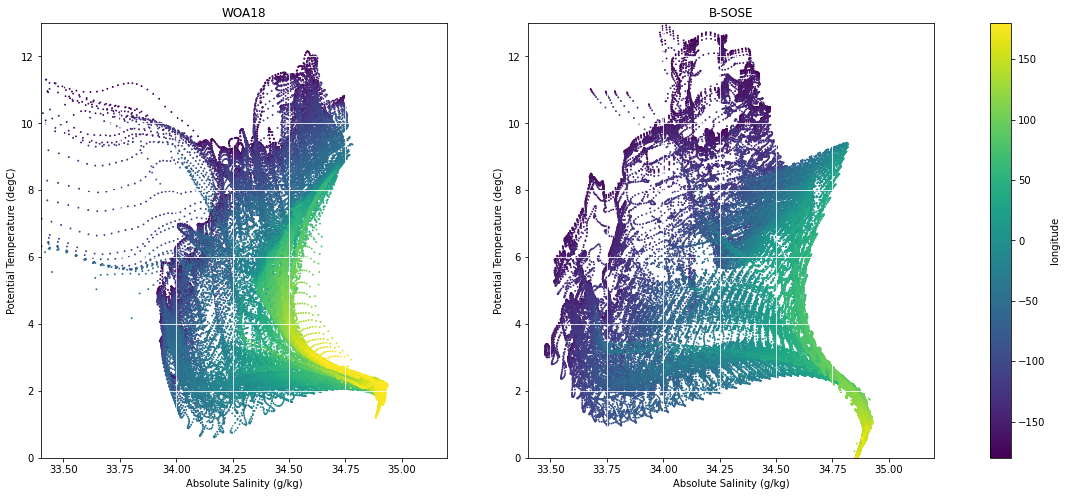

In [99]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].set_title('WOA18')
ax[1].set_title('B-SOSE')

cm = ax[0].scatter(WOA_S.isel(time=0).s_an, WOA_T.isel(time=0).t_an, c=WOA_lons, label='WOA18', s=0.8)
cm = ax[1].scatter(SOSE_S, SOSE_T, c=SOSE_lons, label='B-SOSE', s=0.8)

for axis in ax.ravel():
    axis.set_xlabel('Absolute Salinity (g/kg)')
    axis.set_ylabel('Potential Temperature (degC)')
    axis.set_xlim(33.4, 35.2)
    axis.set_ylim(0, 13)
    axis.grid(c='white')

cb = fig.colorbar(cm, ax=ax, label='longitude')

### Other stuff: 

In [46]:
def plot_WOA_SOSE(month):

    fig, ax = plt.subplots(2,2, figsize=(18,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

    for axis in ax.ravel():
        axis.set_extent([-90, -160, -78, -66], ccrs.PlateCarree())
        cs = axis.contour(SOSE_sal.XC, SOSE_sal.YC, SOSE_sal.Depth, levels=[1000, 2000], 
                          colors='w', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
        gl = axis.gridlines(draw_labels=True);
        gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
    
    #----------------------------- WOA18 -----------------------------
    fig.text(1, 1.1, f'WOA18: 1955-2017 climatology, month: {month:02}, depth: {WOA_temp.depth.values} m', 
             fontweight='bold', transform=ax[0,0].transAxes);
    
    cm1 = ax[0,0].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_an.isel(time=0), 
                             transform=ccrs.PlateCarree(), vmin=34.7, vmax=35.1, rasterized=True)
    CB1 = fig.colorbar(cm1, ax=ax[0,0], fraction=0.03, label='Absolute salinity')
    
    cm2 = ax[0,1].pcolormesh(WOA_temp.lon, WOA_temp.lat, WOA_temp.t_an.isel(time=0), 
                           transform=ccrs.PlateCarree(), vmin=0, vmax=2, rasterized=True)
    CB2 = fig.colorbar(cm2, ax=ax[0,1], fraction=0.03, label='Potential temperature (degC)')
    
    #----------------------------- B-SOSE -----------------------------
    fig.text(1, 1.1, f'B-SOSE: 2013-2021 climatology, month: {month:02}, depth: {-1*SOSE_sal.Z.values:.1f} m', 
             fontweight='bold', transform=ax[1,0].transAxes);
    
    cm3 = ax[1,0].pcolormesh(SOSE_sal.XC, SOSE_sal.YC, SOSE_sal.SALT, 
                             transform=ccrs.PlateCarree(), vmin=34.7, vmax=35.1, rasterized=True)
    CB3 = fig.colorbar(cm3, ax=ax[1,0], fraction=0.03, label='Absolute salinity')
    
    cm4 = ax[1,1].pcolormesh(SOSE_temp.XC, SOSE_temp.YC, SOSE_temp.THETA, 
                           transform=ccrs.PlateCarree(), vmin=0, vmax=2, rasterized=True)
    CB4 = fig.colorbar(cm4, ax=ax[1,1], fraction=0.03, label='Potential temperature (degC)')
    
    land_mask = np.ma.masked_where(SOSE_temp.THETA.values != 0, SOSE_temp.THETA)
    for axis in ax[1,:].ravel():
        axis.pcolormesh(SOSE_temp.XC, SOSE_temp.YC, land_mask, transform=ccrs.PlateCarree(), 
                        cmap=cmocean.cm.gray_r, rasterized=True)
    
    return fig

In [ ]:
depth_level_WOA  = 50
depth_level_SOSE = 37

fig = {}
for month in range(1,13):
    print('Month: ', month)
    
    WOA_sal   = xr.open_dataset(f'{folder_WOA}woa18_decav_s{month:02}_04.nc', 
                               decode_times=False).sel(lat=slice(-78, -65), lon=slice(-160, -90)).isel(depth=depth_level_WOA)
    WOA_temp  = xr.open_dataset(f'{folder_WOA}woa18_decav_t{month:02}_04.nc', 
                               decode_times=False).sel(lat=slice(-78, -65), lon=slice(-160, -90)).isel(depth=depth_level_WOA)
    SOSE_sal  = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m{month:02}.nc').sel(YC=slice(-78,-65), XC=slice(200,270)).isel(Z=depth_level_SOSE)
    SOSE_temp = xr.open_dataset(f'{folder_SOSE}THETA_climatology_m{month:02}.nc').sel(YC=slice(-78,-65), XC=slice(200,270)).isel(Z=depth_level_SOSE)

    # print('     Coverting practical salinity to absolute salinity')
    SOSE_p    = -1* SOSE_sal.Z * 1e-4 * 9.81 * 1035 # value for density makes a tiny difference
    SOSE_sal['SALT'] = gsw.conversions.SA_from_SP(SOSE_sal.SALT, SOSE_p, SOSE_sal.XC, SOSE_sal.YC)  
    WOA_p     = WOA_sal.depth * 1e-4 * 9.81 * 1035 # value for density makes a tiny difference
    WOA_sal['s_an']  = gsw.conversions.SA_from_SP(WOA_sal.s_an, WOA_p, WOA_sal.lon, WOA_sal.lat)  
    
    fig[f'm{month:02}'] = plot_WOA_SOSE(month)
        
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{folder_terra}Amundsen-WOA-SOSE_comparison_{-1*SOSE_sal.Z.values:.0f}m.pdf")
for month in range(1,13):
    pdf.savefig(fig[f'm{month:02}'])
pdf.close()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,10))

for month in range(1,13):
    print(month)
    lat_slice  = slice(-78, -65)
    lon_slice  = slice(-160, -90)
    lon2_slice = slice(200, 270)
    
    WOA_sal = xr.open_dataset(f'{folder_WOA}woa18_decav_s{month:02}_04.nc', 
                                decode_times=False).sel(lat=lat_slice, lon=lon_slice).s_an.isel(time=0)
    WOA_temp = xr.open_dataset(f'{folder_WOA}woa18_decav_t{month:02}_04.nc', 
                                decode_times=False).sel(lat=lat_slice, lon=lon_slice).t_an.isel(time=0).mean(dim=('lat', 'lon'))  
    
    SOSE_temp_m = xr.open_dataset(f'{folder_SOSE}THETA_climatology_m{month:02}.nc').sel(YC=lat_slice, XC=lon2_slice)
    SOSE_sal_m  = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m{month:02}.nc').sel(YC=lat_slice, XC=lon2_slice)
    SOSE_temp   = xr.where(SOSE_temp_m == 0, np.nan, SOSE_temp_m).mean(dim=('YC', 'XC'))
    SOSE_sal    = xr.where(SOSE_sal_m == 0, np.nan, SOSE_sal_m)

    SOSE_p     = -1* SOSE_sal.Z * 1e-4 * 9.81 * 1035 # value for density makes a tiny difference 
    SOSE_sal_n = np.empty(SOSE_sal.SALT.values.shape)
    for depth in range(0,52):
        SOSE_sal_n[depth,:,:] = gsw.conversions.SA_from_SP(SOSE_sal.SALT.isel(Z=depth).values, 
                                                           SOSE_p.isel(Z=depth).values.reshape((1,1)), 
                                                           SOSE_sal.XC.values.reshape((1,420)), 
                                                           SOSE_sal.YC.values.reshape((257,1)))

    SOSE_sal['SALT'] = (('Z','YC','XC'), SOSE_sal_n)
    
    WOA_p     = WOA_sal.depth * 1e-4 * 9.81 * 1035 # value for density makes a tiny difference
    WOA_sal_n = np.empty(WOA_sal.values.shape)
    for depth in range(0,57):
        WOA_sal_n[depth,:,:] = gsw.conversions.SA_from_SP(WOA_sal.isel(depth=depth).values, 
                                                          WOA_p.isel(depth=depth).values.reshape((1,1)), 
                                                          WOA_sal.lon.values.reshape((1,280)), 
                                                          WOA_sal.lat.values.reshape((52,1)))
    WOA_sal['s_an'] = (('depth','lat','lon'), WOA_sal_n)
    # WOA_sal['s_an'] = gsw.conversions.SA_from_SP(WOA_sal.values, WOA_p.values, WOA_sal.lon.values, WOA_sal.lat.values)

    WOA_sal_mean = WOA_sal.mean(dim=('lat', 'lon'))
    SOSE_sal_mean = SOSE_sal.mean(dim=('YC', 'XC'))
    
    ax[0].plot(WOA_temp, WOA_temp.depth, label='_nolabel', c='#2574f4')
    ax[0].plot(SOSE_temp.THETA, -1*SOSE_temp.Z, label='_nolabel', c='#fbbd3c')

    if month==1:
        ax[1].plot(WOA_sal_mean, WOA_sal_mean.depth, label='WOA18', c='#2574f4')
        ax[1].plot(SOSE_sal_mean.SALT, -1*SOSE_sal_mean.Z, label='B-SOSE', c='#fbbd3c')
    else:
        ax[1].plot(WOA_sal_mean, WOA_sal_mean.depth, label='_nolabel', c='#2574f4')
        ax[1].plot(SOSE_sal_mean.SALT, -1*SOSE_sal_mean.Z, label='_nolabel', c='#fbbd3c')

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top') 
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.tick_params(axis='both', which='minor', labelsize=12)
    
ax[0].set_ylabel('Depth (m)', fontsize=12)
ax[0].set_xlabel('Temperature (degC)', fontsize=12)
ax[1].set_xlabel('Salinity (g/kg)', fontsize=12)
ax[1].set_xlim(33,35)
ax[1].set_ylim(2000,-10) 
ax[1].legend(frameon=False, loc=(0.1, 0.6), fontsize=12)

# fig.savefig(f'{folder_terra}TSz_monthly_climatology_BSOSE_WOA18_1955-2017_Amundsen.jpg')
# fig.savefig('/data/oceans_output/shelf/birgal/B-SOSE/TSz_monthly_climatology_BSOSE_WOA18_2005-2017_Amundsen.jpg')
# fig.savefig('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/TSz_monthly_climatology_BSOSE_WOA18_2005-2017_Amundsen.jpg')

##### WOA

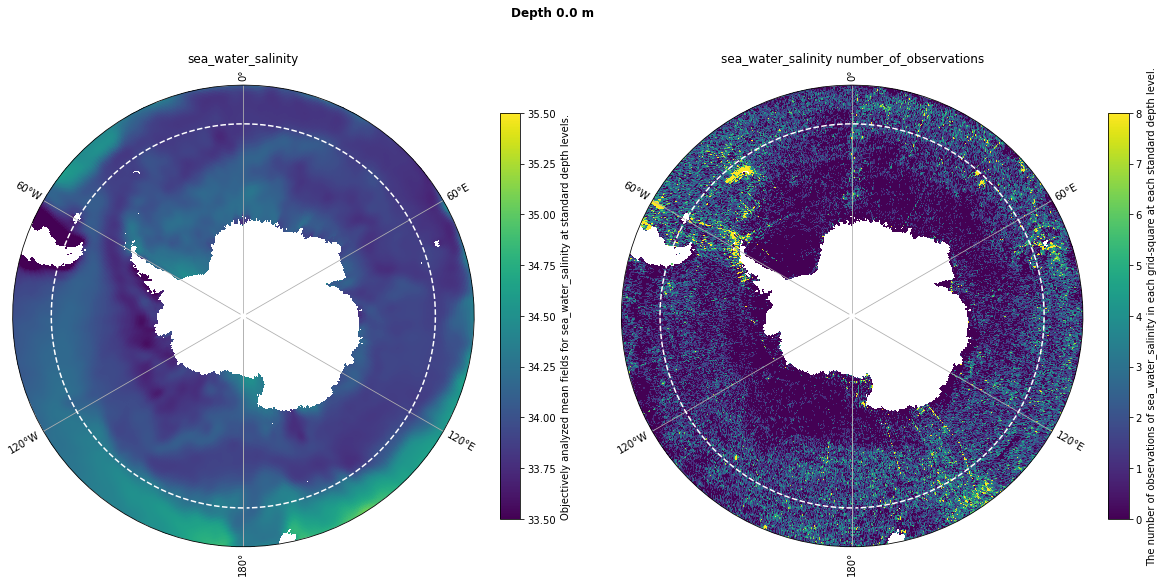

In [34]:
fig, ax = prepare_plot(subs=(1,2), figsize=(20,9))

cm1 = ax[0].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_an.isel(time=0, depth=0), transform=ccrs.PlateCarree(), vmin=33.5, vmax=35.5)
cm2 = ax[1].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_dd.isel(time=0, depth=0), transform=ccrs.PlateCarree(), vmin=0, vmax=8)

ax[0].set_title(WOA_sal.s_an.standard_name)
ax[1].set_title(WOA_sal.s_dd.standard_name)
ax[0].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);
ax[1].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);

CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04, label=WOA_sal.s_an.long_name)
CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04, label=WOA_sal.s_dd.long_name)

fig.suptitle(f'Depth {WOA_sal.depth.values[0]} m', fontweightxr.open_dataset(f'{folder_WOA}woa18_decav_s{month:02}_04.nc', 
                        decode_times=False).sel(lat=lat_slice, lon=lon_slice).s_an.isel(time=0)='bold');

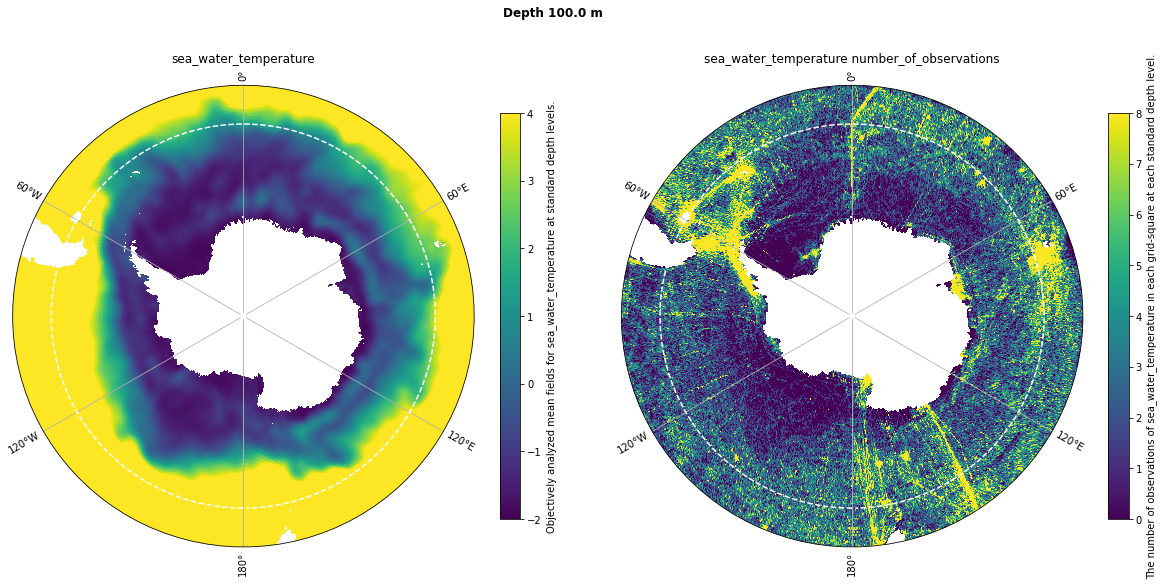

In [38]:
fig, ax = prepare_plot(subs=(1,2), figsize=(20,9))

cm1 = ax[0].pcolormesh(WOA_temp.lon, WOA_temp.lat, WOA_temp.t_an.isel(time=0, depth=20), transform=ccrs.PlateCarree(), vmin=-2, vmax=5)
cm2 = ax[1].pcolormesh(WOA_temp.lon, WOA_temp.lat, WOA_temp.t_dd.isel(time=0, depth=20), transform=ccrs.PlateCarree(), vmin=0, vmax=8)

ax[0].set_title(WOA_temp.t_an.standard_name)
ax[1].set_title(WOA_temp.t_dd.standard_name)
ax[0].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);
ax[1].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);

CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04, label=WOA_temp.t_an.long_name)
CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04, label=WOA_temp.t_dd.long_name)

fig.suptitle(f'Depth {WOA_temp.depth.values[20]} m', fontweight='bold');

In [36]:
for depth in range(0, len(WOA_sal.depth)):
    create_animation(WOA_sal, 's_an', 's_dd', depth, vmin=33.5, vmax=35.5,
                     filename=f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/WOA18/sal_depth_animation/s_an_dd_{depth:03}.jpg')

In [6]:
for depth in range(0, len(WOA_temp.depth)):
    create_animation(WOA_temp, 't_an', 't_dd', depth, vmin=-2, vmax=5, 
                     filename=f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/WOA18/temp_depth_animation/t_an_dd_{depth:03}.jpg')

##### B-SOSE

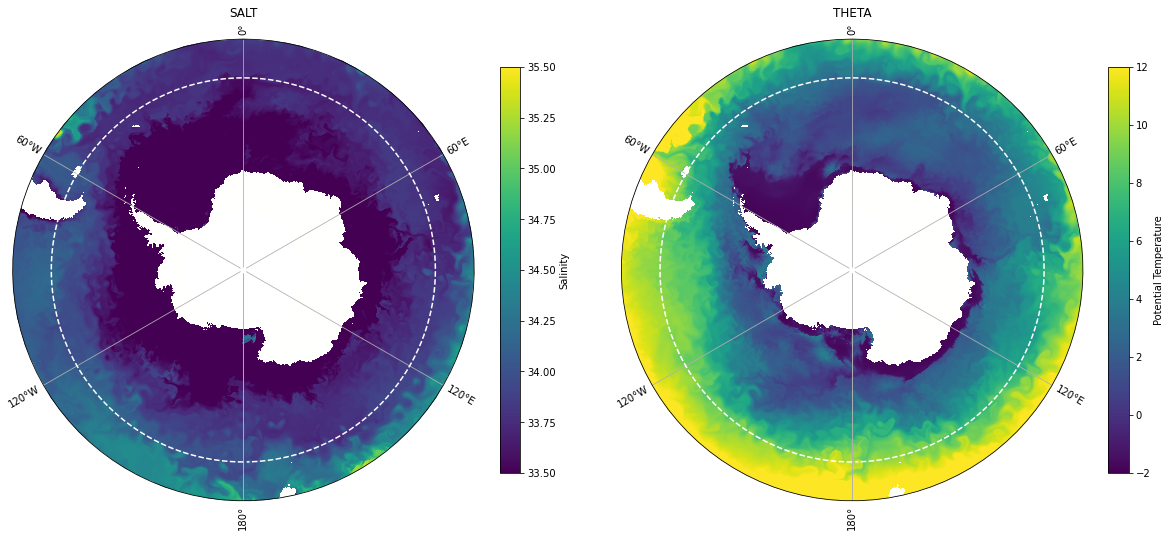

In [7]:
fig, ax = prepare_plot(subs=(1,2), figsize=(20,9))

land_mask = np.ma.masked_where(SOSE_temp.THETA.isel(time=0, Z=0).values != 0, SOSE_temp.THETA.isel(time=0, Z=0))

cm1 = ax[0].pcolormesh(SOSE_sal.XC, SOSE_sal.YC, SOSE_sal.SALT.isel(time=0, Z=0), transform=ccrs.PlateCarree(), vmin=33.5, vmax=35.5)
cm2 = ax[1].pcolormesh(SOSE_temp.XC, SOSE_temp.YC, SOSE_temp.THETA.isel(time=0, Z=0), transform=ccrs.PlateCarree(), vmin=-2, vmax=12)
ax[0].pcolormesh(SOSE_sal.XC, SOSE_sal.YC, land_mask, transform=ccrs.PlateCarree(), cmap=cmocean.cm.gray_r)
ax[1].pcolormesh(SOSE_sal.XC, SOSE_sal.YC, land_mask, transform=ccrs.PlateCarree(), cmap=cmocean.cm.gray_r)

ax[0].set_title(SOSE_sal.SALT.standard_name)
ax[1].set_title(SOSE_temp.THETA.standard_name)
ax[0].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);
ax[1].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);

CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04, label=SOSE_sal.SALT.long_name)
CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04, label=SOSE_temp.THETA.long_name)

# fig.suptitle(f'Depth {WOA_sal.depth.values[0]} m', fontweight='bold');